In [10]:
%pip install lightgbm xgboost imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import warnings, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore")

from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve, roc_curve,
    confusion_matrix
)
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import lightgbm as lgb
import xgboost as xgb

# Reproducibility + business settings
RANDOM_STATE = 42
PRECISION_FLOOR = 0.90      # target precision ≥ 90%
TOP_K_FRACTION = 0.005      # review top 0.5% highest-risk transactions

DATA_CSV = Path("PS_20174392719_1491204439457_log.csv")  # <-- make sure your CSV is here
ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)


In [19]:
import pandas as pd
from pathlib import Path

# Full path to your PaySim CSV
DATA_CSV = Path("/Users/munagalatarakanagaganesh/Documents/Credit card Fraud detection/data/PS_20174392719_1491204439457_log.csv")

assert DATA_CSV.exists(), "Check the file path again"
df = pd.read_csv(DATA_CSV, dtype={
    "nameOrig": "category",
    "nameDest": "category",
    "type": "category"
})

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Basic check 

In [22]:
# Shape, info, missing values
print("Shape:", df.shape)
print("\nData types & memory usage:")
print(df.info(memory_usage="deep"))

print("\nMissing values per column:")
print(df.isna().sum())

# Fraud distribution
fraud_rate = df["isFraud"].mean() * 100
print(f"\nFraud rate: {fraud_rate:.4f}%")

print("\nValue counts for isFraud:")
print(df["isFraud"].value_counts(normalize=True))

# Quick check of 'type' (transaction type)
print("\nTransaction type distribution:")
print(df["type"].value_counts(normalize=True))


Shape: (6362620, 11)

Data types & memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        category
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        category
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int64   
 10  isFlaggedFraud  int64   
dtypes: category(3), float64(5), int64(3)
memory usage: 1.1 GB
None

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud rate: 0.1291%

Value counts for isFraud:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

T

# EDA DATA visualization 

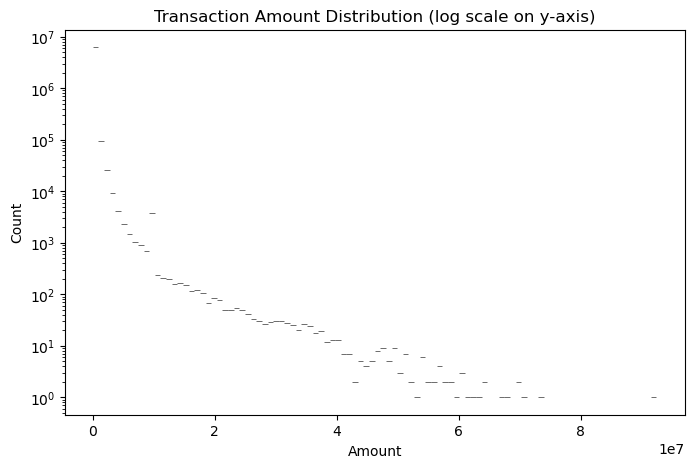

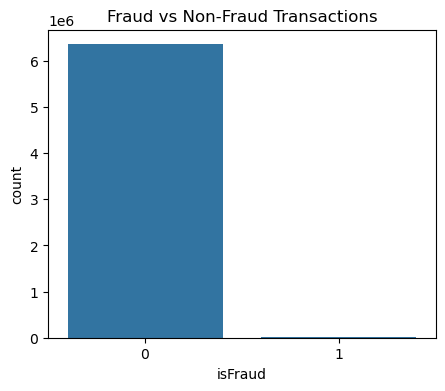

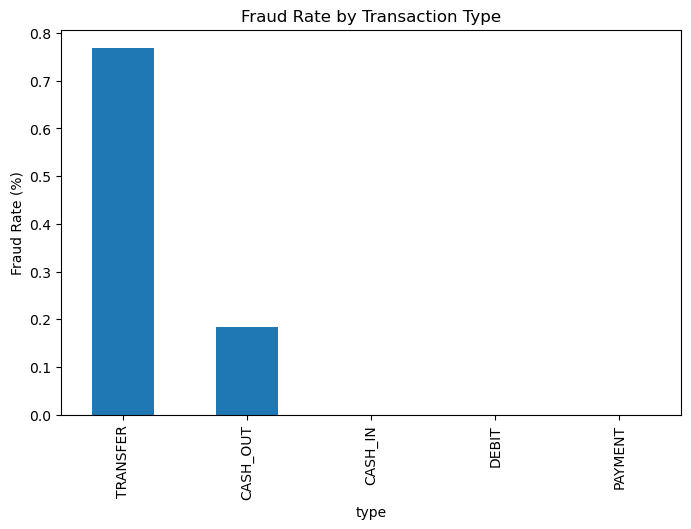

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Transaction amount distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['amount'], bins=100, log_scale=(False, True))
plt.title("Transaction Amount Distribution (log scale on y-axis)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

# --- Fraud vs Non-Fraud counts ---
plt.figure(figsize=(5,4))
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

# --- Fraud rate by transaction type ---
fraud_by_type = df.groupby("type")["isFraud"].mean() * 100
plt.figure(figsize=(8,5))
fraud_by_type.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Transaction Type")
plt.show()


## Feature Selection and Preprocessing

In [29]:
from sklearn.preprocessing import LabelEncoder

# Drop ID-like columns
df_prep = df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"])

# Encode 'type' as numeric
le = LabelEncoder()
df_prep["type"] = le.fit_transform(df_prep["type"])

# Define features & target
X = df_prep.drop(columns=["isFraud"])
y = df_prep["isFraud"]

print("Features:", X.columns.tolist())
print("Target distribution:\n", y.value_counts(normalize=True))


Features: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Target distribution:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [31]:
# Sort by step (time order)
df_prep = df_prep.sort_values("step").reset_index(drop=True)

n = len(df_prep)
cut = int(0.8 * n)

train_val = df_prep.iloc[:cut]
test     = df_prep.iloc[cut:]

print("Train/Val shape:", train_val.shape)
print("Test shape:", test.shape)

# Separate X and y
X_train_val = train_val.drop(columns=["isFraud"])
y_train_val = train_val["isFraud"]

X_test = test.drop(columns=["isFraud"])
y_test = test["isFraud"]

print("Fraud rate Train/Val:", y_train_val.mean()*100, "%")
print("Fraud rate Test:", y_test.mean()*100, "%")


Train/Val shape: (5090096, 8)
Test shape: (1272524, 8)
Fraud rate Train/Val: 0.07777849376514706 %
Fraud rate Test: 0.33429624902948785 %


## Validatoin split + Baseline models

In [36]:
n = len(df_prep)

train_end = int(0.7 * n)       # first 70% → Train
val_end   = int(0.8 * n)       # next 10% → Validation
# last 20% → Test

train = df_prep.iloc[:train_end]
val   = df_prep.iloc[train_end:val_end]
test  = df_prep.iloc[val_end:]

print("Train shape:", train.shape)
print("Val shape:", val.shape)
print("Test shape:", test.shape)

# Features & targets
X_train, y_train = train.drop(columns=["isFraud"]), train["isFraud"]
X_val,   y_val   = val.drop(columns=["isFraud"]), val["isFraud"]
X_test,  y_test  = test.drop(columns=["isFraud"]), test["isFraud"]

print("Fraud rate Train:", y_train.mean()*100, "%")
print("Fraud rate Val:", y_val.mean()*100, "%")
print("Fraud rate Test:", y_test.mean()*100, "%")


Train shape: (4453834, 8)
Val shape: (636262, 8)
Test shape: (1272524, 8)
Fraud rate Train: 0.08170488617222824 %
Fraud rate Val: 0.05029374691557881 %
Fraud rate Test: 0.33429624902948785 %


## Baseline Models 

## Dummy Classifier(sanity check)

In [40]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

val_scores_dummy = dummy.predict_proba(X_val)[:,1]

print("Dummy PR-AUC (val):", average_precision_score(y_val, val_scores_dummy))
print("Dummy ROC-AUC (val):", roc_auc_score(y_val, val_scores_dummy))


Dummy PR-AUC (val): 0.0005029374691557881
Dummy ROC-AUC (val): 0.5


## Logistic regression 

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score

# Scale (robust to outliers) → Logistic Regression with class weights
lr_balanced = Pipeline(steps=[
    ("scale", RobustScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="saga", class_weight="balanced", n_jobs=-1))
])

# Train on the 70% train split
lr_balanced.fit(X_train, y_train)

# Validate on the 10% val split
val_scores_lr_bal = lr_balanced.predict_proba(X_val)[:, 1]
print("LogReg (class_weight='balanced')  PR-AUC (val):", average_precision_score(y_val, val_scores_lr_bal))
print("LogReg (class_weight='balanced')  ROC-AUC (val):", roc_auc_score(y_val, val_scores_lr_bal))


LogReg (class_weight='balanced')  PR-AUC (val): 0.422284946095014
LogReg (class_weight='balanced')  ROC-AUC (val): 0.9802100589558481


## LightGBM Model 

In [53]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score, roc_auc_score

lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Use callbacks for early stopping and verbose logging
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="aucpr",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)

val_scores_lgb = lgbm.predict_proba(X_val)[:, 1]
print("LightGBM PR-AUC (val):", average_precision_score(y_val, val_scores_lgb))
print("LightGBM ROC-AUC (val):", roc_auc_score(y_val, val_scores_lgb))


[LightGBM] [Info] Number of positive: 3639, number of negative: 4450195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0635119
[100]	valid_0's binary_logloss: 0.0159314
[150]	valid_0's binary_logloss: 0.0100071
[200]	valid_0's binary_logloss: 0.00610394
[250]	valid_0's binary_logloss: 0.00382712
[300]	valid_0's binary_logloss: 0.00257071
[350]	valid_0's binary_logloss: 0.00207595
[400]	valid_0's binary_logloss: 0.00170247
[450]	valid_0's binary_logloss: 0.00149

In [55]:
from sklearn.metrics import precision_recall_curve

def choose_threshold(y_true, y_score, precision_floor=0.90):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    import pandas as pd, numpy as np
    df = pd.DataFrame({
        "threshold": np.append(thr, thr[-1]),
        "precision": prec,
        "recall": rec
    })
    df = df[df["precision"] >= precision_floor]
    if len(df) == 0:
        return 0.5  # fallback
    best = df.sort_values(["recall","precision"], ascending=[False, False]).iloc[0]
    return float(best["threshold"])

# Pick threshold on validation set (precision ≥ 90%)
thr = choose_threshold(y_val, val_scores_lgb, precision_floor=0.90)
print("Chosen Threshold:", thr)


Chosen Threshold: 0.965180762582557


## Evaluate on Test set 

PR-AUC (TEST): 0.96368243991209
ROC-AUC (TEST): 0.9994804232823414
Threshold used: 0.965180762582557
Confusion Matrix (TEST):
 [[1268221      49]
 [   1051    3203]]
Precision (TEST): 0.9849323493234933
Recall (TEST): 0.7529384109073813
Precision@top 0.5% (TEST): 0.6541967934611758


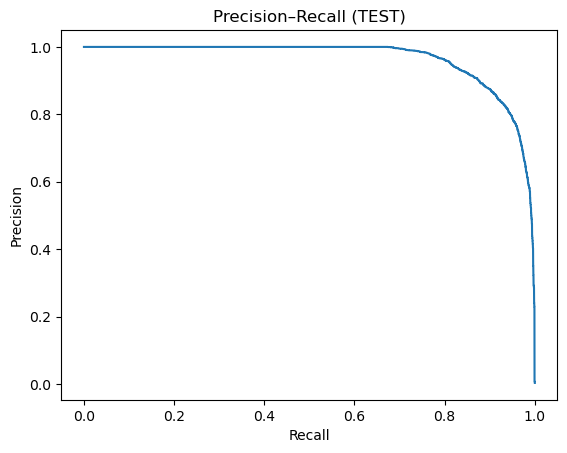

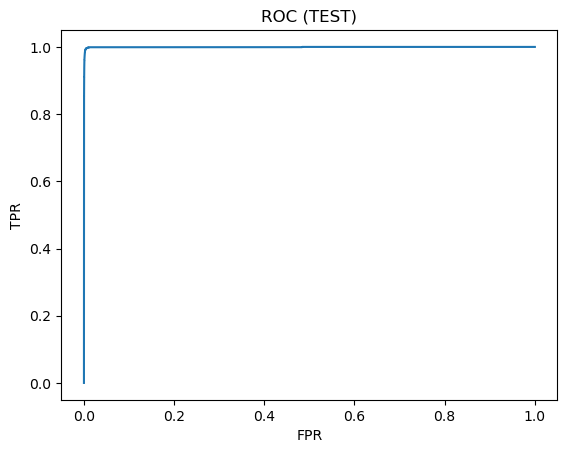

In [64]:
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve,
    roc_curve, confusion_matrix, precision_score, recall_score
)
import matplotlib.pyplot as plt
import numpy as np

# 1) Probabilities on TEST
test_scores = lgbm.predict_proba(X_test)[:, 1]

# 2) Metrics (probability-based)
pr_auc_test  = average_precision_score(y_test, test_scores)
roc_auc_test = roc_auc_score(y_test, test_scores)
print("PR-AUC (TEST):", pr_auc_test)
print("ROC-AUC (TEST):", roc_auc_test)

# 3) Apply threshold from validation
y_pred = (test_scores >= thr).astype(int)

# 4) Confusion matrix + precision/recall at threshold
cm = confusion_matrix(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
print("Threshold used:", thr)
print("Confusion Matrix (TEST):\n", cm)
print("Precision (TEST):", prec)
print("Recall (TEST):", rec)

# 5) Optional: Precision@top-k (e.g., review top 0.5%)
def precision_at_k(y_true, y_score, k_fraction=0.005):
    n = max(1, int(len(y_score) * k_fraction))
    idx = np.argsort(y_score)[::-1][:n]
    return float(np.mean(np.array(y_true)[idx]))

pk = precision_at_k(y_test.values, test_scores, k_fraction=0.005)
print("Precision@top 0.5% (TEST):", pk)

# 6) Curves
prec_curve, rec_curve, _ = precision_recall_curve(y_test, test_scores)
plt.figure(); plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (TEST)"); plt.show()

fpr, tpr, _ = roc_curve(y_test, test_scores)
plt.figure(); plt.plot(fpr, tpr)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (TEST)"); plt.show()

In [59]:
FP_COST = 5.0     # e.g., human review cost ($)
FN_COST = 150.0   # e.g., average loss if fraud is missed

tn, fp, fn, tp = cm.ravel()
expected_cost = fp*FP_COST + fn*FN_COST
print("Expected Cost (TEST): $", expected_cost)


Expected Cost (TEST): $ 157895.0


In [66]:
import joblib, json

# Save model
joblib.dump(lgbm, "artifacts/model_lgbm.joblib")

# Save metrics
metrics = {
    "val": {
        "pr_auc": float(average_precision_score(y_val, val_scores_lgb)),
        "roc_auc": float(roc_auc_score(y_val, val_scores_lgb))
    },
    "test": {
        "pr_auc": float(pr_auc_test),
        "roc_auc": float(roc_auc_test),
        "precision": float(prec),
        "recall": float(rec),
        "precision_at_0.5%": float(pk),
        "threshold": float(thr),
        "confusion_matrix": cm.tolist()
    },
    "expected_cost": float(expected_cost)
}
with open("artifacts/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model + metrics saved in artifacts/")


Model + metrics saved in artifacts/


In [ ]:
# Github

In [68]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix

ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)

# --- PR curve (TEST)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, test_scores)
plt.figure()
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (TEST)")
plt.tight_layout(); plt.savefig(ART_DIR / "pr_curve_test.png"); plt.close()

# --- ROC curve (TEST)
fpr, tpr, _ = roc_curve(y_test, test_scores)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC (TEST)")
plt.tight_layout(); plt.savefig(ART_DIR / "roc_curve_test.png"); plt.close()

# --- Confusion matrix heatmap at chosen threshold
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (TEST)")
plt.colorbar()
tick_marks = [0,1]
plt.xticks(tick_marks, ["Legit","Fraud"]); plt.yticks(tick_marks, ["Legit","Fraud"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig(ART_DIR / "confusion_matrix_test.png"); plt.close()

print("Saved: pr_curve_test.png, roc_curve_test.png, confusion_matrix_test.png")


Saved: pr_curve_test.png, roc_curve_test.png, confusion_matrix_test.png


In [70]:
import json, joblib

joblib.dump(lgbm, ART_DIR / "model_lgbm.joblib")

metrics = {
    "val": {
        "pr_auc": float(average_precision_score(y_val, val_scores_lgb)),
        "roc_auc": float(roc_auc_score(y_val, val_scores_lgb))
    },
    "test": {
        "pr_auc": float(pr_auc_test),
        "roc_auc": float(roc_auc_test),
        "precision": float(prec),
        "recall": float(rec),
        "precision_at_0.5pct": float(pk),
        "threshold": float(thr),
        "confusion_matrix": cm.tolist()
    }
}
with open(ART_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved: model_lgbm.joblib, metrics.json")


Saved: model_lgbm.joblib, metrics.json


In [76]:
import json, datetime
from pathlib import Path

ART_DIR = Path("artifacts")
with open(ART_DIR / "metrics.json") as f:
    M = json.load(f)

VAL_PRAUC  = M["val"]["pr_auc"]
VAL_ROCAUC = M["val"]["roc_auc"]

T_PRAUC  = M["test"]["pr_auc"]
T_ROCAUC = M["test"]["roc_auc"]
T_PREC   = M["test"]["precision"]
T_RECALL = M["test"]["recall"]
T_PK     = M["test"]["precision_at_0.5pct"] if "precision_at_0.5pct" in M["test"] else M["test"].get("precision_at_0_5pct", None)
THR      = M["test"]["threshold"]
CM       = M["test"]["confusion_matrix"]

readme = (
    "# Fraud Detection (PaySim) — LightGBM\n\n"
    "End-to-end fraud detection on the **PaySim** dataset (~6.3M transactions).\n"
    "Focus: **extreme class imbalance**, **time-aware split**, **business-oriented thresholding**, and **high-precision triage**.\n\n"
    "##  Results\n\n"
    "**Validation**\n"
    f"- PR-AUC: **{VAL_PRAUC:.4f}**\n"
    f"- ROC-AUC: **{VAL_ROCAUC:.6f}**\n\n"
    "**Test**\n"
    f"- PR-AUC: **{T_PRAUC:.4f}**\n"
    f"- ROC-AUC: **{T_ROCAUC:.6f}**\n"
    f"- Threshold (from val, P≥90%): **{THR:.4f}**\n"
    f"- Precision (at threshold): **{T_PREC:.4f}**\n"
    f"- Recall (at threshold): **{T_RECALL:.4f}**\n"
    f"- Precision@Top 0.5%: **{(T_PK if T_PK is not None else float('nan')):.4f}**\n\n"
    f"**Confusion Matrix (Test at threshold)**\n`[[TN, FP], [FN, TP]] = {CM}`\n\n"
    '<img src="artifacts/pr_curve_test.png" width="420"> <img src="artifacts/roc_curve_test.png" width="420">\n\n'
    "##  Data\n"
    "**PaySim** simulated financial transactions with labels:\n"
    "- Features used: `step, type, amount, oldbalanceOrg, newbalanceOrg, oldbalanceDest, newbalanceDest`\n"
    "- Dropped IDs: `nameOrig, nameDest`; Dropped `isFlaggedFraud`\n"
    "- Target: `isFraud`\n\n"
    "##  Methodology\n"
    "- **Time-aware split**: 70% Train → 10% Val → 20% Test (ordered by `step`)\n"
    "- **Model**: LightGBM (`class_weight='balanced'`) with early stopping\n"
    "- **Metrics**: PR-AUC primary; ROC-AUC secondary\n"
    "- **Thresholding**: choose threshold on **Val** to meet **Precision ≥ 90%**, then evaluate on **Test**\n"
    "- **Artifacts**: PR/ROC curves, confusion matrix, feature importance, saved model\n\n"
    "## How to run\n"
    "1) Install deps\n"
    "```bash\n"
    "pip install pandas numpy scikit-learn lightgbm imbalanced-learn xgboost matplotlib joblib\n"
    "```\n"
    "2) Open the notebook and set the path to your PaySim CSV.\n"
    "3) Run cells top → bottom. Artifacts & metrics save to `artifacts/`.\n\n"
    "##  Notes & Limitations\n"
    "- PaySim is simulated; production performance depends on real data distributions.\n"
    "- IDs were dropped to avoid overfitting and privacy leakage.\n"
    "- Always tune thresholds to **business costs** (review cost vs missed-fraud loss).\n\n"
    f"_Last updated: {datetime.date.today().isoformat()}_\n"
)

Path("README.md").write_text(readme, encoding="utf-8")
print("Wrote README.md ")


Wrote README.md 
